In [1]:
# Import packages
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import os
import re
import json
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Define the inputs
country_of_choice = "United Arab Emirates"

# Upload the geo data to BigQuery
is_upload = False # False by default so users don't accidentally overwrite existing data in BQ

std_lvls = ["2", "3"] # Standard levels of the GADM data. NO need to change this

#############################################################################################################################################  
**<center>#--------STARTING HERE, YOU DON'T NEED TO DEFINE ANY OTHER INPUTS--------#</center>**  
#############################################################################################################################################

### Set the current working directory to ~/global_pricing/customer_location/shape_files

In [3]:
if "shape_files" in os.getcwd():
    pass
else:
    try:
        os.chdir(f"{os.getcwd()}/customer_location/shape_files") # If the current working directory is ~/global_pricing
    except FileNotFoundError:
        os.chdir(f"{os.getcwd()}/shape_files") # If the current working directory is ~/global_pricing/customer_location

### Load the country_codes from the json file

In [4]:
with open("../country_codes.json", mode="r", encoding="utf-8") as f:
    country_codes = json.load(f)

### Instantiate a BigQuery client

In [5]:
client = bigquery.Client(project="logistics-customer-staging")
bqstorage_client = bigquery_storage.BigQueryReadClient()

### Iterate over each country in the country_codes list

In [6]:
for iso in country_codes:
    # List all the shape files that end with ".shp" and contain the 3-letter country code
    shp_files = [i for i in os.listdir(os.getcwd()) if i.endswith(".shp") and iso in i]

    # Loop over all levels of the shape file and create separate data frames with a suffix indicating the level (i.e., 0, 1, 2, etc). The highest level is 3
    for idx, shp in enumerate(shp_files):
        vars()[f"df_gpd_{iso.lower()}_" + str(idx)] = gpd.read_file(os.getcwd() + "/" + shp)


In [7]:
# List the first five elements of the list containing the names of all the data frames that were created in the last step
df_gpd_list = [i for i in dir() if i.startswith("df_gpd_")]
print("The first five elements of the list containing the names of all the data frames that were created in the last step are:")
df_gpd_list[0:5]

The first five elements of the list containing the names of all the data frames that were created in the last step are:


['df_gpd_are_0',
 'df_gpd_are_1',
 'df_gpd_are_2',
 'df_gpd_are_3',
 'df_gpd_arg_0']

### Merge the data frames that have common levels together

In [8]:
# Declare empty lists to store the data frames that will be merged
# First, create a list of all geo spatial levels in df_gpd_list
geo_spatial_levels = pd.Series([i[-1] for i in df_gpd_list if i[-1].isnumeric()]).drop_duplicates().to_list()
for i in geo_spatial_levels:
    vars()["df_gpd_" + i] = [] # This will create lists in the format df_gpd_0 = [], df_gpd_1 = [], df_gpd_2 = [], etc.

# Iterate over the raw list of data frames and append them to the lists created above
for i in df_gpd_list:
    for j in geo_spatial_levels:
        if i[-1] == j: # If the suffix of the data frame matches the suffix of the list, append the data frame to the list
            vars()["df_gpd_" + j].append(vars()[i])
        else:
            pass

# Concat all the data frames in each list
for i in geo_spatial_levels:
    vars()["df_gpd_" + i] = pd.concat(vars()["df_gpd_" + i]) # This is equivalent to df_gpd_0 = pd.concat(df_gpd_0), df_gpd_1 = pd.concat(df_gpd_1), etc.
    vars()["df_gpd_" + i] = vars()["df_gpd_" + i].reset_index(drop=True)
    vars()["df_gpd_" + i]["gid_level"] = i # Create a column that indicates the level of the geo spatial data frame

### Plot the GADM data of levels (2 and 3) in the country defined in the first step

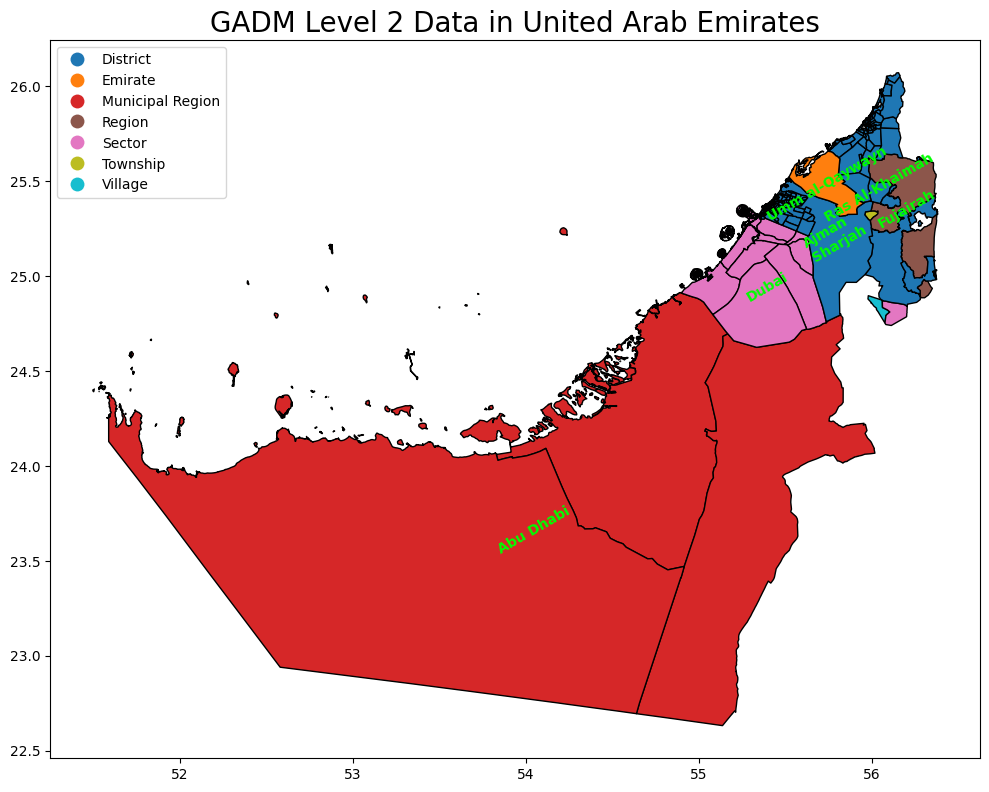

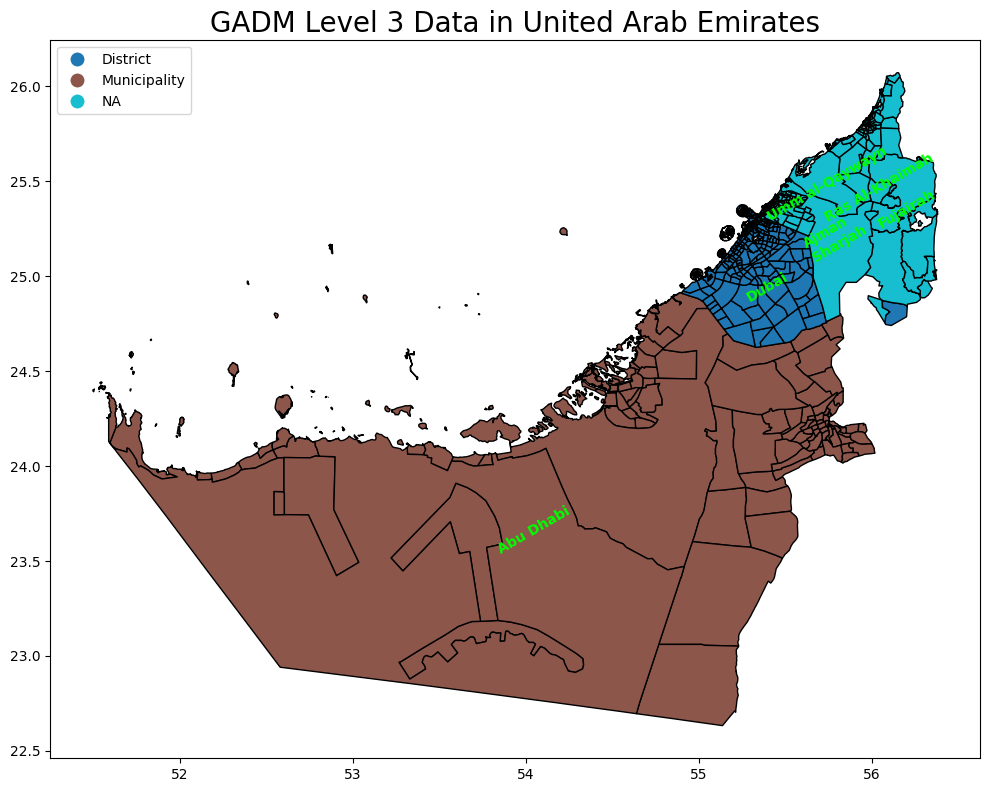

In [23]:
# P.S. Your IDE might show there is a problem with "df_gpd_{x}", but there is actually no problem. It's just that df_gpd_{x} was created paramterically without being explicitly declared
for lvl in std_lvls:
    # Create a data frame for plotting the GADM data of levels 2, and 3 in the country of choice
    df_plot = vars()[f"df_gpd_" + lvl][vars()[f"df_gpd_" + lvl]["COUNTRY"] == country_of_choice]

    # Create a data frame for superimposing the city names from GADM data level 1
    df_text = df_gpd_1[df_gpd_1["COUNTRY"] == country_of_choice]

    ax = df_plot.plot(column=f"ENGTYPE_{lvl}", legend=True, figsize=(10, 10), edgecolor="black", legend_kwds={"loc": "upper left"})

    # Iterate through the GeoDataFrame and add text labels for each geometry
    for idx, row in df_text.iterrows():
        # Get the name from the 'name' column (replace with the actual column name)
        city_name = row['NAME_1']
        
        # Get the centroid of the geometry
        centroid = row['geometry'].centroid
        
        # Add the text label at the centroid coordinates
        ax.text(centroid.x, centroid.y, city_name, fontsize=10, ha='center', va='center', color="lime", fontweight="bold", rotation=30)

    plt.title(f"GADM Level {lvl} Data in " + country_of_choice, fontsize=20)
    plt.tight_layout()

#############################################################################################################################################  
**<center>#--------PLEASE EXECUTE THE NEXT CELL WITH CAUTION AS IT WILL OVERWRITE EXISTING DATA IN BIGQUERY--------#</center>**  
#############################################################################################################################################

In [9]:
if is_upload == True:
    # Define a job config to upload data to BigQuery
    job_config = bigquery.LoadJobConfig()
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

    # Upload the combined data frames to BigQuery
    df_gpd_merged_list = [i for i in dir() if re.findall(pattern="df_gpd_[0-9]", string=i)]
    for i in df_gpd_merged_list:
        print(f"Uploading {i} to BigQuery...")

        # Change the column names to lower case
        vars()[i].columns = vars()[i].columns.str.lower()

        # Change the geometry column to a string
        vars()[i]["geometry"] = vars()[i]["geometry"].apply(lambda x: str(x))

        # Upload the data frames to BigQuery
        client.load_table_from_dataframe(
            dataframe=vars()[i],
            destination=f"logistics-data-storage-staging.long_term_pricing.gadm_geo_spatial_data_level_{i[-1]}",
            job_config=job_config
        )

Uploading df_gpd_0 to BigQuery...
Uploading df_gpd_1 to BigQuery...
Uploading df_gpd_2 to BigQuery...
Uploading df_gpd_3 to BigQuery...
Uploading df_gpd_4 to BigQuery...
